## Pipelines

- The main reason for this is that GBMs has no good way to introduce sample weights
- To add GBMs with resampling

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
import sklearn.metrics as metrics

## Read in data grouped by bookings

In [2]:
df = pd.read_pickle("outputs/df_grouped.pickle")

## Split data into training and testing

- Try different testing and training sizes although not expecting much of a difference

In [3]:
features = df.iloc[:, :-1]
response = df.iloc[:, -1]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    response,
    test_size=0.2,
    random_state=42
)

## Model Pipelines
- Define pipelines
    - GBM
    - Logisitc Regresion
    - Logistic Regression with PCA
    - Random Forests
    - Random Forests with PCA
- Define GS grids
- To add in grid search parameters

In [5]:
jobs = -1
pipe_gbm = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", GradientBoostingClassifier(random_state=42))
    ]
)

pipe_lr = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", LogisticRegression(random_state=42))
    ]
)

pipe_lr_pca = Pipeline(
    [
        ("scl", StandardScaler()),
        ("pca", PCA(n_components=2)),
        ("clf", LogisticRegression(random_state=42))
    ]
)

pipe_rf = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42, class_weight=None))
    ]
)

pipe_rf_pca = Pipeline(
    [
        ("scl", StandardScaler()),
        ("pca", PCA(n_components=2)),
        ("clf", RandomForestClassifier(random_state=42, class_weight=None))
    ]
)

In [6]:
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_gbm = [
    {}
    ]

grid_params_lr = [
    {}
] 

grid_params_rf = [
    {
    }
]

In [7]:
gs_gbm = GridSearchCV(
    estimator=pipe_gbm,
    param_grid=grid_params_gbm,
    scoring="roc_auc",
    cv=10,
    n_jobs=jobs
)

gs_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=grid_params_lr,
    scoring="roc_auc",
    cv=10
) 

gs_lr_pca = GridSearchCV(
    estimator=pipe_lr_pca,
    param_grid=grid_params_lr,
    scoring="roc_auc",
    cv=10
)

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=grid_params_rf,
    scoring="roc_auc",
    cv=10, 
    n_jobs=jobs
)

gs_rf_pca = GridSearchCV(
    estimator=pipe_rf_pca,
    param_grid=grid_params_rf,
    scoring="roc_auc",
    cv=10, 
    n_jobs=jobs
)

In [8]:
grids = [
    gs_gbm, 
    gs_lr, 
    gs_lr_pca, 
    gs_rf, 
    gs_rf_pca
]

grid_dict = {
    0: "Gradient Boosted Machine",
    1: "Logistic Regression", 
    2: "Logistic Regression w/PCA", 
    3: "Random Forest", 
    4: "Random Forest w/PCA", 
}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Gradient Boosted Machine
Best params: {}
Best training accuracy: 0.752
Test set accuracy score for best params: 0.686 

Estimator: Logistic Regression
Best params: {}
Best training accuracy: 0.717
Test set accuracy score for best params: 0.653 

Estimator: Logistic Regression w/PCA
Best params: {}
Best training accuracy: 0.622
Test set accuracy score for best params: 0.593 

Estimator: Random Forest
Best params: {}
Best training accuracy: 0.953
Test set accuracy score for best params: 0.909 

Estimator: Random Forest w/PCA
Best params: {}
Best training accuracy: 0.920
Test set accuracy score for best params: 0.859 

Classifier with best test set accuracy: Random Forest


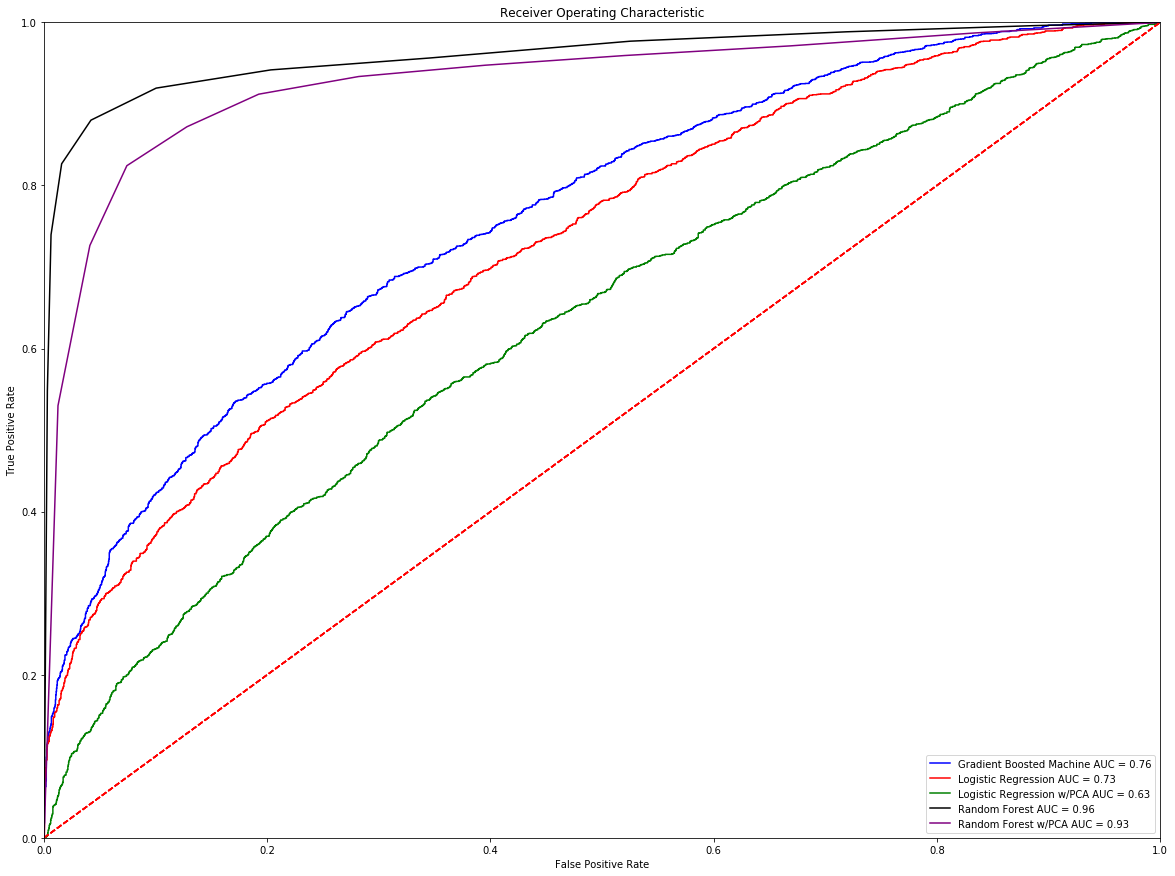

In [9]:
color_dict = {
    0: "blue",
    1: "red", 
    2: "green", 
    3: "black", 
    4: "purple", 
}
plt.figure(figsize=(20, 15))
for idx, gs in enumerate(grids):
    probs = gs.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(
        fpr, 
        tpr, 
        color=color_dict[idx], 
        label = '%s AUC = %0.2f' % (grid_dict[idx], roc_auc)
    )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()

## Plot feature importances

In [10]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced").fit(X_train, y_train)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

<BarContainer object of 16 artists>

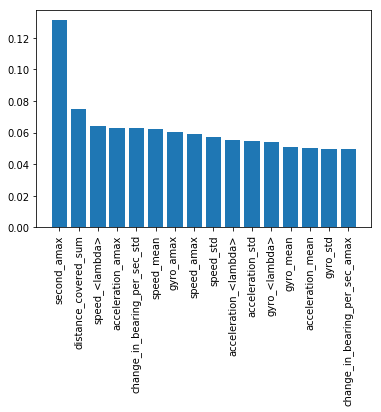

In [11]:
plt.xticks(rotation=90)
plt.bar(feature_importances.index, feature_importances["importance"])

## Cross validation
- Check if there is data leakage?
- A sudden jump to 90% accuracy seems dubious

In [15]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cross_val_score(
    pipe_rf, 
    X_train, 
    y_train, 
    cv=cv
)

array([0.87291667, 0.88625   , 0.87645833, 0.88583333, 0.876875  ,
       0.88020833, 0.88541667, 0.88375   , 0.88604167, 0.883125  ])